In [54]:
#import required libraries
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xlwings as xw
from statsmodels.formula.api import ols
import scipy.stats
from scipy.stats import linregress
from scipy.stats import t
plt.style.use(['seaborn-darkgrid'])

In [55]:
#extract user defined inputs from spreadsheet
wb = xw.Book('Project.xlsx')
analysis = wb.sheets[0]
prices_sh = wb.sheets[1]
symbol_1 = analysis.range("C7").value
symbol_2 = analysis.range("E7").value
start_date = analysis.range("G7").value
end_date = analysis.range("J7").value

In [56]:
#extract data, drop na values, and create additional date columns
df=pd.DataFrame(yf.download(tickers=[symbol_1,symbol_2],start=start_date,end=end_date,thread=False)['Adj Close'])
prices = df
df = df.pct_change()
df.reset_index(inplace=True)
df['Year'] = df['Date'].dt.year
df['Week_Num'] = df['Date'].dt.week
df.set_index('Date',inplace=True)
df.dropna(inplace=True)

[*********************100%***********************]  2 of 2 completed


## Part A: Visualization

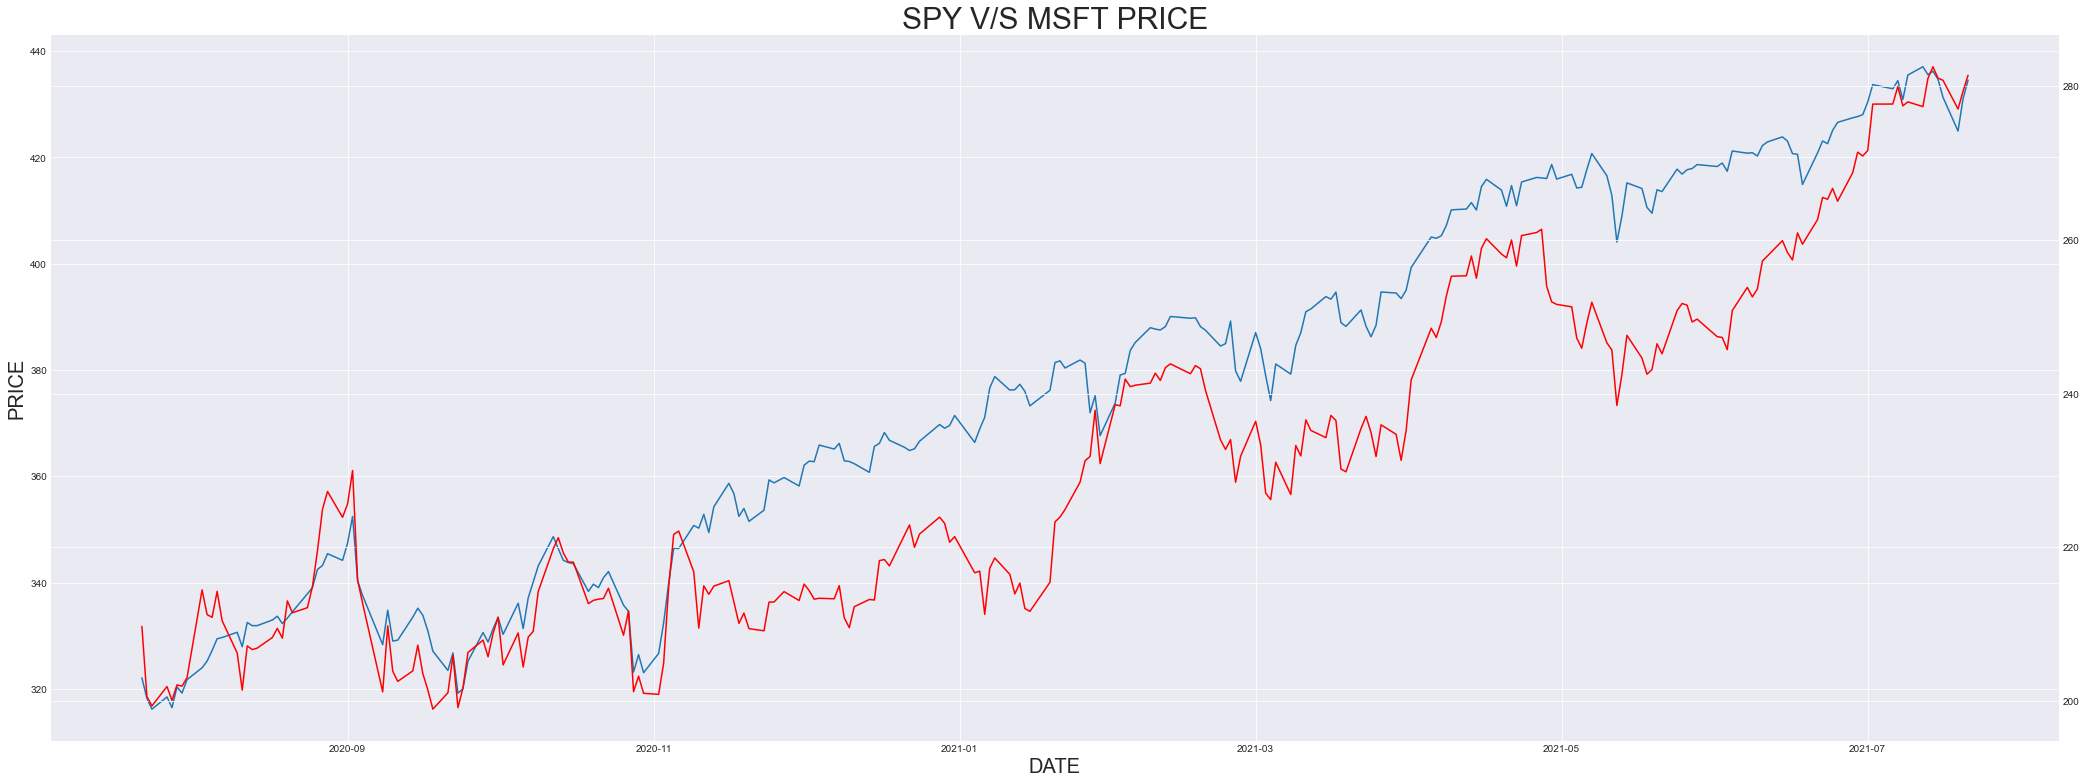

In [61]:
x=prices.index
y1=prices[symbol_1]
y2=prices[symbol_2]
visual,ax1=plt.subplots(figsize = (36, 13))
plt.title(symbol_1+ " V/S "+symbol_2+" PRICE",fontsize=30)
plt.xlabel('DATE',fontsize=20)
plt.ylabel('PRICE',fontsize=20)
ax2=ax1.twinx()
curve1=ax1.plot(x,y1,label=symbol_1)
curve2=ax2.plot(x,y2,label=symbol_2,color='red')

In [62]:
#add visualization to dashboard
analysis.pictures.add(visual,name="visualization",update=True,left=analysis.range("C8").left,
                      top=analysis.range("C8").top,scale=.30)

<Picture 'visualization' in <Sheet [Project.xlsx]Dashboard>>

## Part B: Prices & Returns

In [6]:
#Populate Prices & Returns section of the dashboard with First/Last/Max/Min prices
analysis.range('F12').value = prices.iloc[0][0]
analysis.range('F13').value = prices[prices.columns[0]].max()
analysis.range('F14').value = prices[prices.columns[0]].min()
analysis.range('F15').value = prices.iloc[-1][0]
analysis.range('J12').value = prices.iloc[0][1]
analysis.range('J13').value = prices[prices.columns[1]].max()
analysis.range('J14').value = prices[prices.columns[1]].min()
analysis.range('J15').value = prices.iloc[-1][1]
#add raw data to prices tab
prices_sh.range('A1').expand().clear_contents()
prices_sh.range("A1").value = prices

## Part C: Performance Simulation Code:

In [ ]:
#extract user defined allocations 
asset1_allocation = analysis.range('L22').value
asset2_allocation = analysis.range('L23').value

In [17]:
#establish an index originating from 100 to calculate the hypothetical growth of $100
#calculate return index for each secuirty & the weighted return specified by user allocations  
index_1 = [100]
index_2 = [100]
weighted = [100]
for i in range(0,len(df)):
    weighted_return = (df[df.columns[0]][i] * asset1_allocation) + (df[df.columns[1]][i] * asset2_allocation) 
    value_1 = (1 + (df[df.columns[0]][i])) * index_1[i]
    value_2 = (1 + (df[df.columns[1]][i])) * index_2[i]
    value_3 = (1 + weighted_return) * weighted[i]
    index_1.append(value_1)
    index_2.append(value_2)
    weighted.append(value_3)
indexed_returns  = pd.DataFrame(index_1,columns=[df.columns[0]])
indexed_returns[df.columns[1]] = index_2
indexed_returns['Weighted Returns'] = weighted
dates = df.index.strftime('%m-%d-%y').to_list()
dates.insert(0,0)
indexed_returns['Date'] = dates
indexed_returns.set_index('Date',inplace=True)


In [18]:
#identify ending balance
analysis.range('L24').value = indexed_returns.iloc[-1][2]

Text(0.5, 1.0, 'Hypothetical Growth of $100')

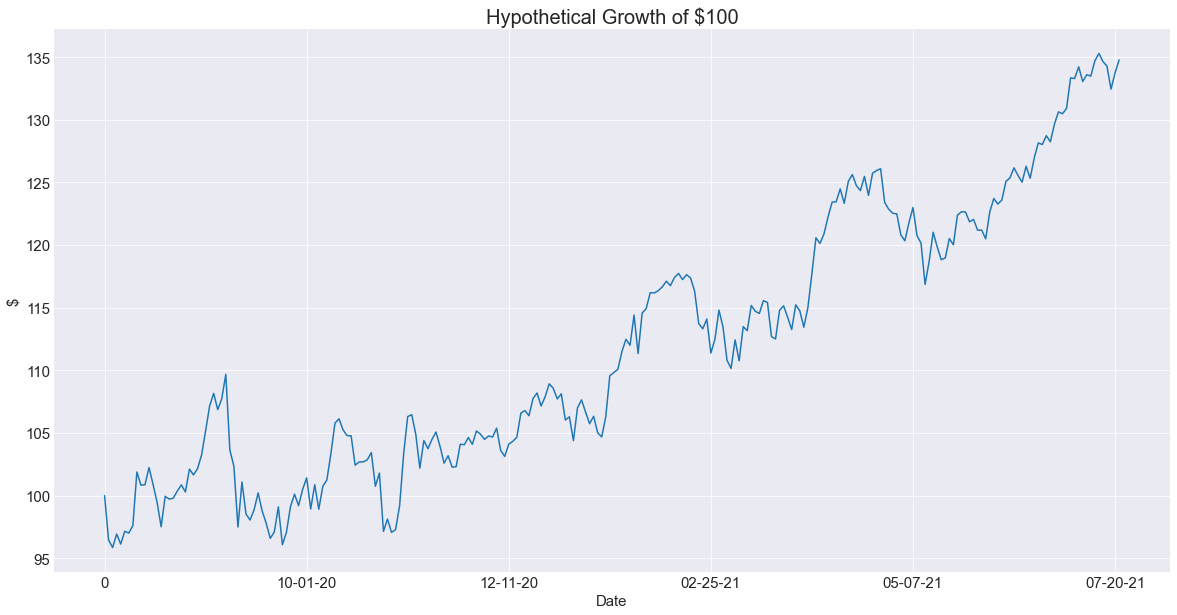

In [43]:
#create performance simulation line chart
figure = plt.figure(figsize=(20,10))
indexed_returns['Weighted Returns'].plot(kind='line',figsize=(20,10))
plt.xlabel('Date',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('$',fontsize=15)
plt.title('Hypothetical Growth of $100',fontsize=20)

In [20]:
#add performance simulation visual to dashboard
analysis.pictures.add(figure,name="Allocation",update=True,left=analysis.range("C20").left,
                      top=analysis.range("C20").top + 10,scale=.38)

<Picture 'Allocation' in <Sheet [Project.xlsx]Dashboard>>

## Part D: Regression Analysis

In [7]:
#normalize the data
prices[symbol_1] = prices[symbol_1]/prices[symbol_1].max()
prices[symbol_2] =prices[symbol_2]/prices[symbol_2].max()

Text(0, 0.5, 'MSFT returns')

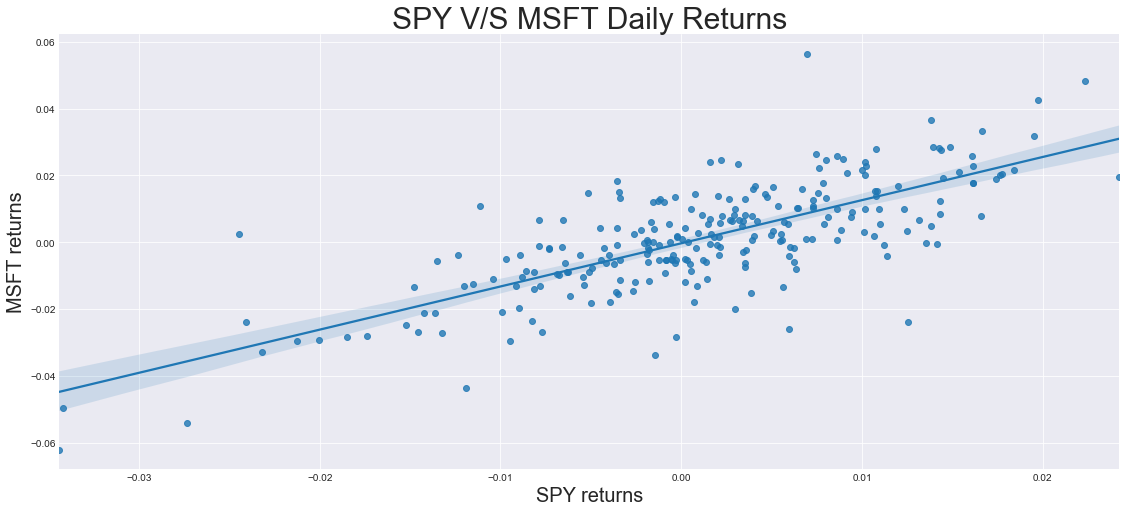

In [21]:
#create scatter plot regression visualization
import seaborn as sns
x = prices[symbol_1]
xret = x.pct_change()[1:]

y = prices[symbol_2]
yret = y.pct_change()[1:]

fig_3= plt.figure(figsize=(19,8))
plt.title(symbol_1+ " V/S "+symbol_2+" Daily Returns",fontsize=30)
sns.regplot(x=xret,y= yret)
plt.xlabel(symbol_1+' returns',fontsize=20)
plt.ylabel(symbol_2+' returns',fontsize=20)

In [22]:
#add visual to dashboard
analysis.pictures.add(fig_3,name="Regression Analysis",update=True,left=analysis.range("C39").left,
                      top=analysis.range("C39").top + 12,scale=.4)

<Picture 'Regression Analysis' in <Sheet [Project.xlsx]Dashboard>>

In [10]:
# scipy regression statistics
beta, alpha, r, p, stderr = linregress(xret, yret)
Beta=  round(beta, 2)
Alpha= round(alpha,4)
Rcoef=r
Rsquared=round(r**2,1)
Pvalue= p
stddev= round(stderr,6)
obs = len(prices)

In [11]:
#input statistics into spreadsheet
regr_list = [obs,Rcoef, Beta,Alpha, Rsquared,Pvalue]
analysis.range("L41").options(transpose = True).value = regr_list

## Part E: Rolling Correlation Code

In [12]:
rolling_corr = [] #establish rolling correlation list to capture the data
for year in df.Year.unique(): #perform the same process for each year
    week_exclusion = [] #establish list to exclude weeks with less than 4 data points
    current_year = df[df['Year']==year] #filter the data frame by year
    week_counts = current_year.Week_Num.value_counts() #count the number of days in each week 
    for i in (week_counts.index): #loop through each week and evaluate the number of days)
        num_of_days = week_counts[i] #establish num_of_days variable
    if num_of_days < 4: #if the num of days is less than 4 then add to a week exclusion list
        week_exclusion.append(i)
    for i in week_exclusion: #loop through each week and exclude those data points from the data frame
        if week_exclusion.index(i)==0:
            corr_data = current_year
        else:
            corr_data = corr_data[corr_data['Week_Num']!=i]
    for i in corr_data['Week_Num'].unique(): #for each remaining week calculate the correlation of returns
        rolling_corr.append(corr_data[corr_data['Week_Num']==i].index[-1]) #record last date in the week
        rolling_corr.append(corr_data[corr_data['Week_Num']==i].corr().values[1,0])  #record correlation

In [13]:
#convert data into a pandas dataframe 
test = pd.DataFrame(np.reshape(rolling_corr,(int(len(rolling_corr)/2),2)),columns=['Date','Correlation'])
test.set_index('Date',inplace=True)

Text(0.5, 1.0, 'SPY vs MSFT Rolling Correlations')

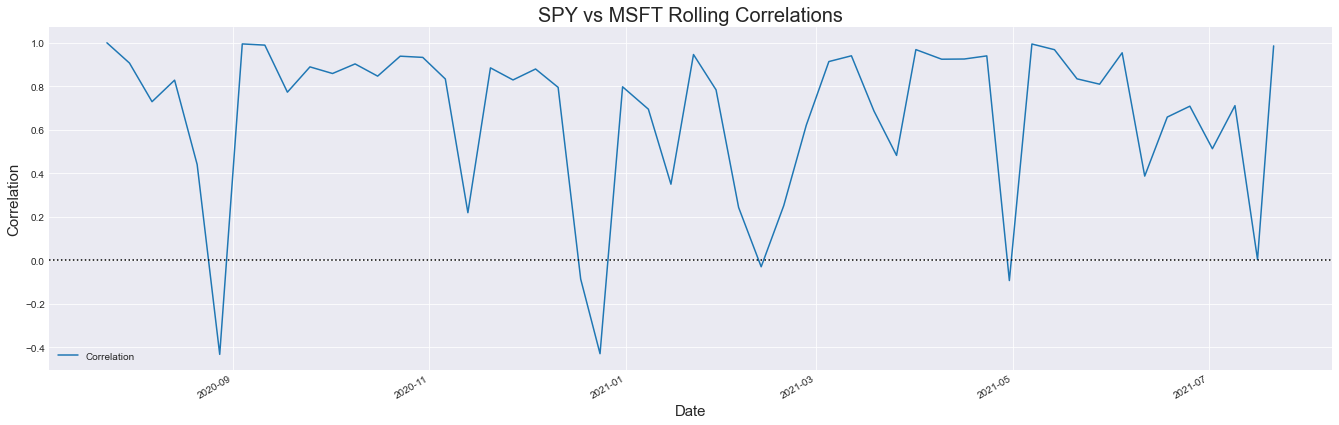

In [67]:
#output line chart with dotted line at 0 to better delineate correlation fluctuations
ax = test.plot(kind='line',figsize=(23,7))
fig = ax.get_figure()
plt.axhline(y=0.0, color='black', linestyle='dotted')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Correlation',fontsize=15)
plt.title(symbol_1 + " "+'vs' +" "+ symbol_2+" "+ 'Rolling Correlations',fontsize=20)




In [68]:
#add image to spreadsheet
analysis.pictures.add(fig,name='MyPlot',update=True,left=analysis.range('C63').left,
                     top=analysis.range('C63').top,scale=.47)

<Picture 'MyPlot' in <Sheet [Project.xlsx]Dashboard>>